In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import matplotlib
from PIL import Image
import pickle

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


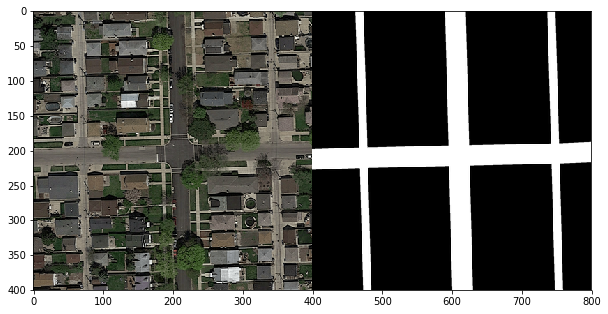

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [6]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [7]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0



In [ ]:
def append_features(patches,list_functions):
    a = []
    for i in patches:
        b = []
        for pixel in i:
            c = pixel
            for f in list_functions:
                c = np.append([pixel], f(pixel))
            b.append(c)
        a.append(b)
    return np.array(a)

def f(pixel):
    return pixel.mean()

list_function = [f]

print(append_features(img_patches[0],[f]))

In [10]:
X = np.asarray(img_patches)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [11]:
print(X.shape)

(62500, 16, 16, 3)


In [12]:
from sklearn import cross_validation
from sknn.mlp import Classifier, Layer, Convolution

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
create_new_model = True
model_name = "nnP"+str(patch_size)+"yolo"

In [29]:
if create_new_model:
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2)
    # Create a neural network that uses convolution to scan the input images.
    nn = Classifier(
        layers=[
            Convolution('Rectifier', channels=12, kernel_shape=(10, 10), border_mode='full'),
            #Convolution('Rectifier', channels=12, kernel_shape=(16, 3), border_mode='full'),
            #Convolution('Rectifier', channels=12, kernel_shape=(3, 16), border_mode='full'),
            Convolution('Rectifier', channels=8, kernel_shape=(5, 5), border_mode='valid'),
            Layer('Rectifier', units=64),
            Layer('Softmax')],
        learning_rate=0.002,
        valid_size=0.2,
        n_stable=10,
        verbose=True)
    nn.fit(X, Y)
    pickle.dump(nn, open(model_name+'.pkl', 'wb'))
else:
    nn = pickle.load(open(model_name+'.pkl', 'rb'))
    

# Determine how well it does on training data and unseen test data.
print('\nTRAIN SCORE', nn.score(X_train, y_train))
print('TEST SCORE', nn.score(X_test, y_test))

y_pred = nn.predict(X_test)

Initializing neural network with 4 layers, 768 inputs and 2 outputs.
  - Convl: Rectifier  Output: (25, 25)   Channels: 12
  - Convl: Rectifier  Output: (21, 21)   Channels: 8
  - Dense: Rectifier  Units:  64  
  - Dense: Softmax    Units:  2   

Training on dataset of 62,500 samples with 48,125,000 total size.
  - Reshaping input array from (62500, 16, 16, 3) to (50000, 3, 16, 16).
  - Train: 50,000     Valid: 12,500
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1         ..............................................                                                            5.286e-01             4.986e-01        267.5s
    2         ..............................................                                                            4.958e-01             4.814e-01        253.3s
    3         ..............................................             

KeyboardInterrupt: 

In [18]:
print(y_pred.shape)

(12500, 1)


In [19]:
def load_training_img(idx):
    img_patches = [img_crop(imgs[idx], patch_size, patch_size)]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    return np.asarray(img_patches)

In [20]:
def showTrainingPred(img_idx):
    Xi = load_training_img(img_idx)
    Zi = nn.predict(Xi)
    # Display prediction as an image

    w = gt_imgs[img_idx].shape[0]
    h = gt_imgs[img_idx].shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    cimg = concatenate_images(imgs[img_idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs[img_idx], predicted_im)

    plt.imshow(new_img)

[(625, 2)]


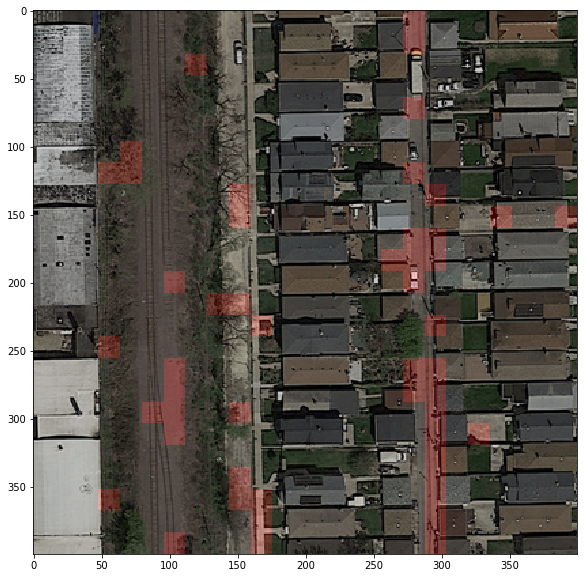

In [21]:
showTrainingPred(19)

In [22]:
def load_test_imgs():
    #1444 tiles per image
    n=50
    test_directory = "test_set_images/test_"
    imgs = [load_image(test_directory + str(i)+"/test_"+str(i)+".png") for i in range(1,n+1)]
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    return imgs, np.asarray(img_patches)

imgs_test, a = load_test_imgs()

In [23]:
print(a.shape)

(72200, 16, 16, 3)


In [24]:
yolo = nn.predict(a)

[(72200, 2)]


In [25]:
print(yolo.shape)

(72200, 1)


In [26]:
def showTestImg(idx):

    w = 608
    h = 608
    size= 1444
    predicted_im = label_to_img(w, h, patch_size, patch_size, yolo[size*idx:size*(idx+1)])
    cimg = concatenate_images(imgs_test[idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs_test[idx], predicted_im)

    plt.imshow(new_img)

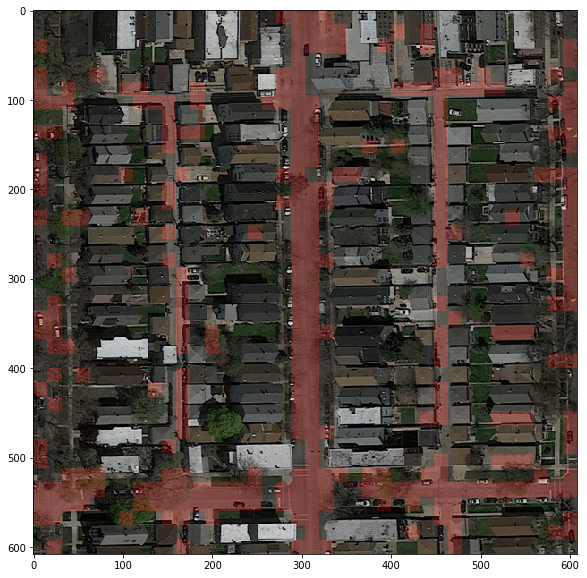

In [27]:
#la 5, 6 et 8 sont pas mal
idx_test = 5
showTestImg(idx_test)

In [28]:
def saveTestImgsOutput():
    w = 608
    h = 608
    size = 1444
    for i in range(50):
        predicted_im = label_to_img(w, h, patch_size, patch_size, yolo[size*i:size*(i+1)])
        nameToSave = 'test_set_results/img_'+str(i+1)+'.png'
        G = np.zeros((w,h,3))
        G[predicted_im>0.5] = [1,1,1]
        G[predicted_im<0.5] = [0,0,0]
        matplotlib.image.imsave(nameToSave, G)
saveTestImgsOutput()

In [ ]:
import cv2

In [ ]:
yoloimg = cv2.imread("training\images\satImage_007.png",0)

In [ ]:
ret3,th3 = cv2.threshold(yoloimg,0,50,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize=(20,10))
plt.imshow(th3,'gray')

In [ ]:
def imgPatch2img(img, patch_size):
    return img[::patch_size, ::patch_size]

In [ ]:
img = cv2.imread("training\images\satImage_007.png")
print(len(img))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(gray,1,np.pi/180,400,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)
print(len(lines))
plt.imshow(img)

In [ ]:
img = cv2.imread('training\images\satImage_007.png')
blur = cv2.blur(img,(5,5))
gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
if lines is not None:
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(gray)

In [ ]:
# Read image
img = cv2.imread('training\images\satImage_007.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh)

In [ ]:
# Read image
im = cv2.imread('training\images\satImage_007.png', cv2.IMREAD_GRAYSCALE)

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 200


# Filter by Area.
params.filterByArea = True
params.minArea = 1500

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87
    
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
	detector = cv2.SimpleBlobDetector(params)
else : 
	detector = cv2.SimpleBlobDetector_create(params)


# Detect blobs.
keypoints = detector.detect(im)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob

im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs

In [ ]:
import cv2
im = cv2.imread('training\images\satImage_007.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,"gray")

G = im
G[im<0.5] = 0
G[im>0.5] = 1
plt.imshow(G,"gray")

In [ ]:
from sklearn import datasets, cross_validation
from sknn.mlp import Classifier, Layer, Convolution


# Load the data and split it into subsets for training and testing.
digits = datasets.load_digits()
X = digits.images
y = digits.target

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)


# Create a neural network that uses convolution to scan the input images.
nn = Classifier(
    layers=[
        Convolution('Rectifier', channels=12, kernel_shape=(3, 3), border_mode='full'),
        Convolution('Rectifier', channels=8, kernel_shape=(3, 3), border_mode='valid'),
        Layer('Rectifier', units=64),
        Layer('Softmax')],
    learning_rate=0.002,
    valid_size=0.2,
    n_stable=10,
    verbose=True)

nn.fit(X_train, y_train)


# Determine how well it does on training data and unseen test data.
print('\nTRAIN SCORE', nn.score(X_train, y_train))
print('TEST SCORE', nn.score(X_test, y_test))

y_pred = nn.predict(X_test)


# Show some training images and some test images too.
import matplotlib.pyplot as pylab

for index, (image, label) in enumerate(zip(digits.images[:6], digits.target[:6])):
    pylab.subplot(2, 6, index + 1)
    pylab.axis('off')
    pylab.imshow(image, cmap=pylab.cm.gray_r, interpolation='nearest')
    pylab.title('Training:%i' % label)

for index, (image, prediction) in enumerate(zip(X_test[:6], y_pred[:6])):
    pylab.subplot(2, 6, index + 7)
    pylab.axis('off')
    pylab.imshow(image.reshape((8,8)), cmap=pylab.cm.gray_r, interpolation='nearest')
    pylab.title('Predicts:%i' % prediction)

pylab.show()